<a href="https://colab.research.google.com/github/darthwaydr007/gan/blob/master/adverserialtrain_pgd_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import random
scaler = torch.cuda.amp.GradScaler() 
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU')
    device = torch.device("cpu")

There are 1 GPU available.
GPU: Tesla K80


In [2]:
torch.FloatTensor(16, ).uniform_(0.8, 1.2)

tensor([1.1156, 1.1173, 1.1670, 1.1887, 1.1344, 1.1134, 1.1177, 0.9941, 0.8972,
        0.8359, 1.0551, 1.0746, 1.1719, 0.9773, 0.9530, 0.8536])

In [3]:
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [4]:
BATCH_SIZE = 128
nc = 3
nz = 100
ngf = 128
ndf = 128
LR = 2e-3
img_dim = 32
CLASSES = 10
epsilon = 0.1
steps = 10

In [5]:
transform=transforms.Compose([
                               #transforms.Resize(img_dim),
                               
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomCrop(32, padding=4),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

                           ])

mnist_train = datasets.CIFAR10(root='/content/drive/My Drive/MNIST', train=True, download=True, transform=transform)
mnist_test = datasets.CIFAR10(root='/content/drive/My Drive/MNIST', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train , batch_size = BATCH_SIZE, shuffle = True , drop_last=True,num_workers=10)
test_loader = torch.utils.data.DataLoader(mnist_test , batch_size = BATCH_SIZE , shuffle = False , drop_last=True,num_workers=10)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def display_grid(images):
    grid_img = torchvision.utils.make_grid(images , nrow=16)
    npimgs = grid_img.cpu().detach().numpy()
    npimgs = npimgs*0.5+0.5
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='gray')
    plt.show()

In [7]:
#display_grid(images)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model_head = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf*4) x 4 x 4
        )

        self.classes = nn.Sequential(
            nn.Linear(ndf*4*4*4,CLASSES),
            nn.LogSoftmax()
        )
        self.disc = nn.Sequential(
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)
            
        )

    def forward(self, input):
        out = self.model_head(input)
        flatten = out.view(-1 , ndf*4*4*4)
        disc = self.disc(out).view(BATCH_SIZE,1)
        classes = self.classes(flatten)
        return {
            'disc_output' : disc.cuda(),
            'disc_classes' : classes.cuda(),
            'features' : flatten.cuda()
        }

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #self.emb = nn.Embedding(CLASSES, nz)
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            #nn.Dropout(0.3),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Dropout(0.3),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            #nn.Dropout(0.3),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.model(input).cuda()

In [10]:
class Cifar10Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_head = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.classes = nn.Sequential(
            nn.Linear(ndf*4*4*4,CLASSES),
            nn.LogSoftmax()
        )
    def forward(self, input):
        out = self.model_head(input)
        flatten = out.view(-1 , ndf*4*4*4)
        classes = self.classes(flatten)
        return classes.cuda()

In [11]:
def fgsm(img , epsilon , data_grad):
  new_image = img.cuda() + epsilon*data_grad.cuda().sign()
  new_image = torch.clamp(new_image, -1, 1)
  return new_image

In [12]:
def perturb_image_QQ(img , Model , label , GAN):
  temp_img = img.clone()
  temp_img.requires_grad = True
  output = Model(temp_img)
  if GAN == True:
    loss = criterion_aux(output['disc_classes'] , label)
  else:
    loss = criterion_aux(output , label)
  loss.backward()
  data_grad = temp_img.grad.data
  Model.zero_grad()        
  new_image = fgsm(temp_img , epsilon , data_grad)
  return new_image

In [13]:
def perturb_image_pgd(img , Model , label , GAN , steps = steps , epsilon= epsilon):
  alpha  = epsilon/50
  temp_img = img.clone()
  temp_img.requires_grad = True
  delta = torch.zeros_like(img, requires_grad=True)
  for _ in range(steps):
    with torch.cuda.amp.autocast():
      output = Model(temp_img+delta)
      if GAN == True:
        loss = criterion_aux(output['disc_classes'] , label)
      else:
        loss = criterion_aux(output , label)
    scaler.scale(loss).backward()
    delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
    Model.zero_grad()
    delta.grad.zero_()
  return (temp_img + delta)

In [14]:
G = Generator().to(device)
D = Discriminator().to(device)
criterion_disc = nn.BCEWithLogitsLoss()
criterion_aux = nn.NLLLoss()
D_optimizer = optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))

In [15]:
classifier = Cifar10Classifier().to(device)
optimizer = optim.Adam(classifier.parameters(), lr = LR, betas=(0.5, 0.999))

In [16]:
def D_train_adverserial(x , label , train):
  #x_real, y_real = x.view(BATCH_SIZE, nc, img_dim, img_dim).cuda(), torch.ones(BATCH_SIZE, 1).cuda()
  x_real, y_real = x.view(BATCH_SIZE, nc, img_dim, img_dim).cuda(),torch.FloatTensor(BATCH_SIZE,1 ).uniform_(0.8, 1.1).cuda()
  fake_label = torch.randint(10 , (BATCH_SIZE,)).cuda()
  onehot = torch.zeros(BATCH_SIZE, CLASSES)
  onehot[np.arange(BATCH_SIZE), fake_label] = 1
  noise = torch.randn(BATCH_SIZE, nz)
  noise[np.arange(BATCH_SIZE) , :CLASSES] = onehot[np.arange(BATCH_SIZE)]
  z = noise.view(BATCH_SIZE, nz, 1, 1).to(device) 
  if train == True:
    G.train()
    D.train()
    D.zero_grad()

    # train discriminator on real
    #x_fake, y_fake = G(z), torch.zeros(BATCH_SIZE, 1).to(device)
    x_fake, y_fake = G(z), torch.FloatTensor(BATCH_SIZE,1 ).uniform_(0, 0.3).cuda()
    img = x_real.clone()
    x_perturb = perturb_image_pgd(img , D , label , GAN = True)

    with torch.cuda.amp.autocast():
      data = D(x_real)
      D_output1_disc = data['disc_output']
      D_output1_aux = data['disc_classes']
      D_real_disc_loss = criterion_disc(D_output1_disc, y_real)
      D_real_aux_loss = criterion_aux(D_output1_aux , label)
      D_real_loss = D_real_disc_loss+D_real_aux_loss
    #D_real_loss.backward(retain_graph = True)
    scaler.scale(D_real_loss).backward(retain_graph = True)

    with torch.cuda.amp.autocast():
      data = D(x_perturb)
      D_output1_discP = data['disc_output']
      D_output1_auxP = data['disc_classes']
      D_real_disc_lossP = criterion_disc(D_output1_discP, y_real)
      D_real_aux_lossP = criterion_aux(D_output1_auxP , label)
      D_real_lossP = D_real_disc_lossP+D_real_aux_lossP
      #D_real_lossP = D_real_lossP*0.5
    #D_real_lossP.backward()
    scaler.scale(D_real_lossP).backward()

    D_real_clasf_loss = D_real_aux_lossP + D_real_aux_loss
    # train discriminator on fake
    with torch.cuda.amp.autocast():
      data = D(x_fake)
      D_output2_disc = data['disc_output']
      D_output2_aux = data['disc_classes']
      D_fake_disc_loss = criterion_disc(D_output2_disc, y_fake)
      D_fake_aux_loss = criterion_aux(D_output2_aux, fake_label)
      D_fake_loss = D_fake_disc_loss+D_fake_aux_loss
    #D_fake_loss.backward()
    scaler.scale(D_fake_loss).backward()

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_aux_lossP + D_real_aux_loss
    #D_loss.backward()
    #D_optimizer.step()
    scaler.step(D_optimizer) 
    scaler.update() 
    #print(D_output1_aux.shape)
    return {
        'loss' : D_real_clasf_loss.data.item() ,
        'outputP' : D_output1_auxP,
        'output' : D_output1_aux
    }
  else:
    with torch.cuda.amp.autocast():
      D.eval()
      data = D(x_real)
      D_output1_disc = data['disc_output']
      D_output1_aux = data['disc_classes']
    return {
        'loss' : D_output1_disc ,
        'output' : D_output1_aux
    }
  


In [17]:
def G_train(label):
    G.train()
    D.train()
    G.zero_grad()
    
    z = torch.randn(BATCH_SIZE, nz, 1, 1).to(device)
    fake_label = torch.randint(10 , (BATCH_SIZE,))
    onehot = torch.zeros(BATCH_SIZE, CLASSES)
    onehot[np.arange(BATCH_SIZE), label] = 1
    noise = torch.randn(BATCH_SIZE, nz)
    noise[np.arange(BATCH_SIZE) , :CLASSES] = onehot[np.arange(BATCH_SIZE)]
    z = noise.view(BATCH_SIZE, nz, 1, 1).to(device)

    y0 = torch.FloatTensor(BATCH_SIZE,1 ).uniform_(0.8, 1).cuda()
    with torch.cuda.amp.autocast():
      G_output = G(z)
      data = D(G_output)
      D_output_disc = data['disc_output']
      D_output_aux = data['disc_classes']
      G_disc_loss = criterion_disc(D_output_disc, y0)
      G_aux_loss = criterion_aux(D_output_aux , label)
      G_loss = G_disc_loss+G_aux_loss

    # gradient backprop & optimize ONLY G's parameters
    #G_loss.backward()
    scaler.scale(G_loss).backward()
    #G_optimizer.step()
    scaler.step(G_optimizer) 
    G.zero_grad()
    scaler.update() 
        
    return G_loss.data.item() , G_output

In [18]:
Accuracy_GAN_train = []
Accuracy_GAN_test = []
Accuracy_GAN_FGSM = []

In [19]:
Accuracy_Clasf_train = []
Accuracy_Clasf_test = []
Accuracy_Clasf_FGSM = []

In [20]:
n_epoch = 10



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


alomst 100
alomst 100


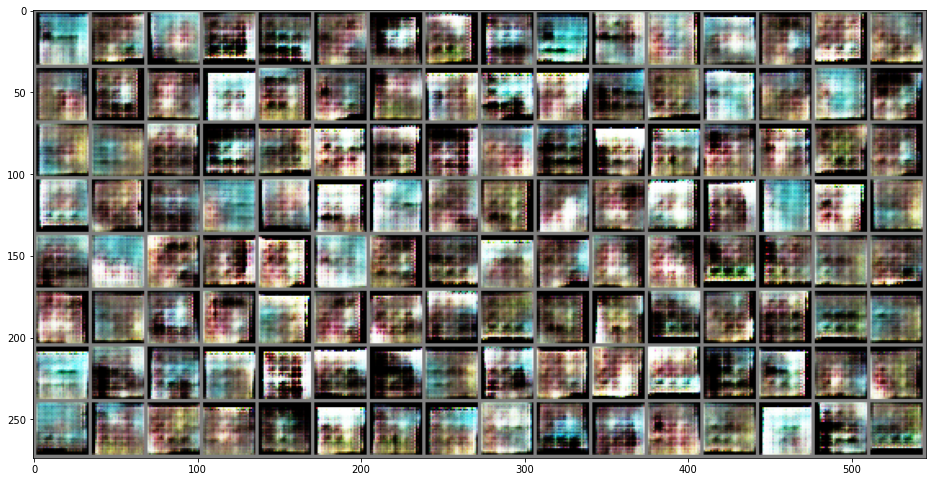

alomst 100
[1/10]: loss_d: 4.308, loss_g: 2.169
Accuracy Training regular:  0.3504
Accuracy Training adv:  0.2359
Accuracy Testing :  0.4154
Accuracy PGD:  0.282
alomst 100
alomst 100


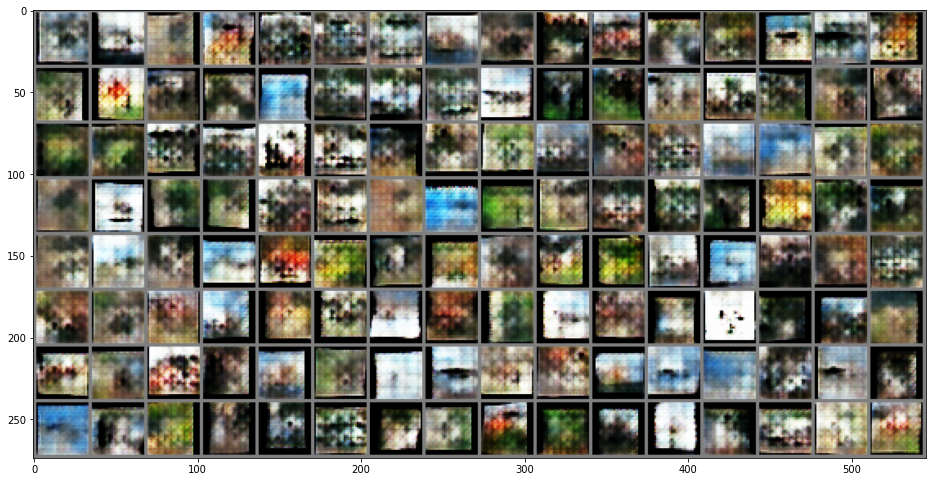

alomst 100
[2/10]: loss_d: 3.434, loss_g: 1.396
Accuracy Training regular:  0.4718
Accuracy Training adv:  0.316
Accuracy Testing :  0.5157
Accuracy PGD:  0.344
alomst 100
alomst 100


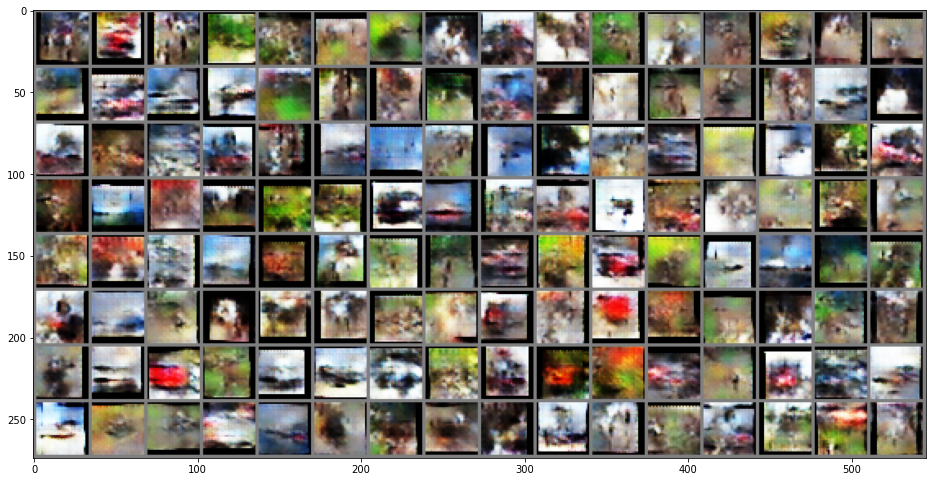

alomst 100
[3/10]: loss_d: 3.123, loss_g: 1.143
Accuracy Training regular:  0.533
Accuracy Training adv:  0.357
Accuracy Testing :  0.5515
Accuracy PGD:  0.3643
alomst 100
alomst 100


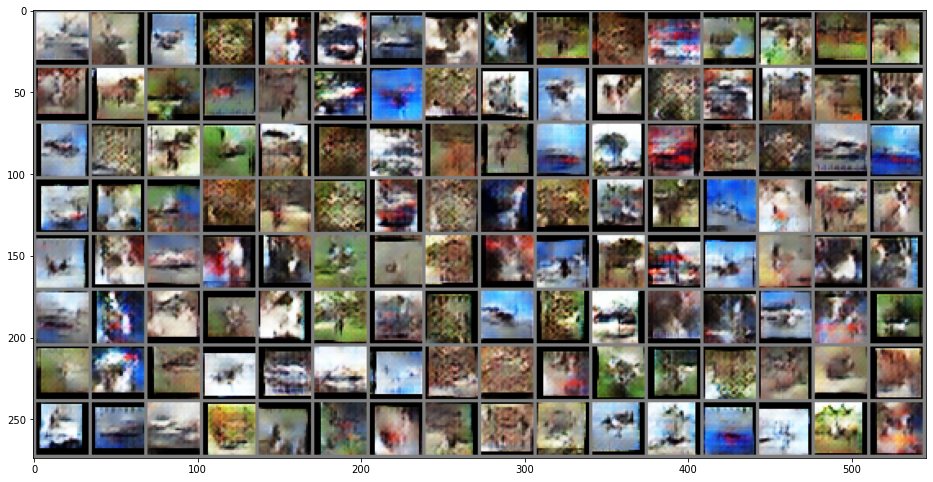

alomst 100
[4/10]: loss_d: 2.926, loss_g: 1.059
Accuracy Training regular:  0.5754
Accuracy Training adv:  0.3837
Accuracy Testing :  0.5897
Accuracy PGD:  0.3907
alomst 100
alomst 100


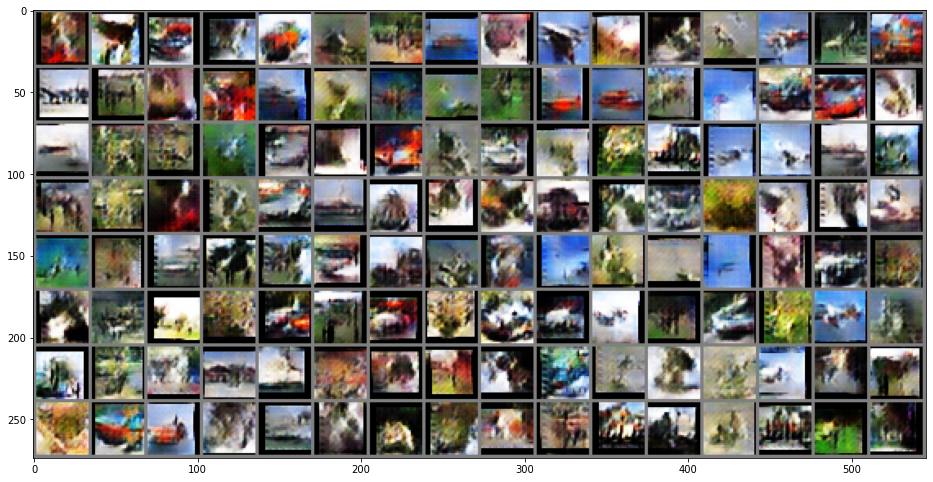

alomst 100
[5/10]: loss_d: 2.794, loss_g: 1.059
Accuracy Training regular:  0.6065
Accuracy Training adv:  0.4023
Accuracy Testing :  0.5768
Accuracy PGD:  0.3743
alomst 100
alomst 100


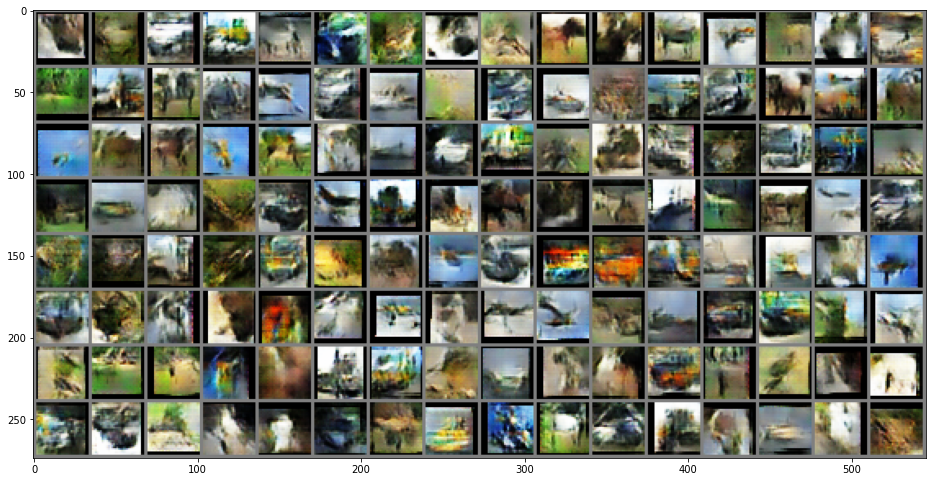

alomst 100
[6/10]: loss_d: 2.693, loss_g: 1.024
Accuracy Training regular:  0.6258
Accuracy Training adv:  0.4167
Accuracy Testing :  0.6378
Accuracy PGD:  0.4224
alomst 100
alomst 100


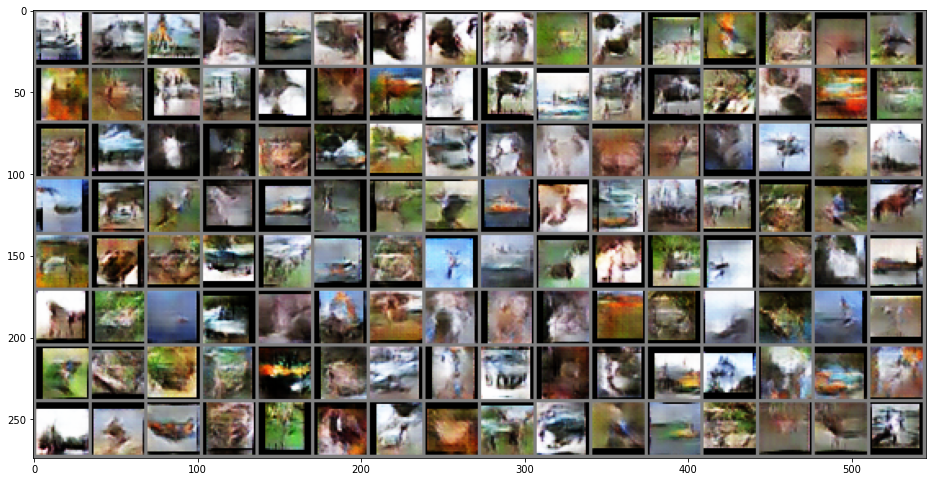

alomst 100
[7/10]: loss_d: 2.607, loss_g: 0.990
Accuracy Training regular:  0.6456
Accuracy Training adv:  0.4298
Accuracy Testing :  0.651
Accuracy PGD:  0.4393
alomst 100
alomst 100


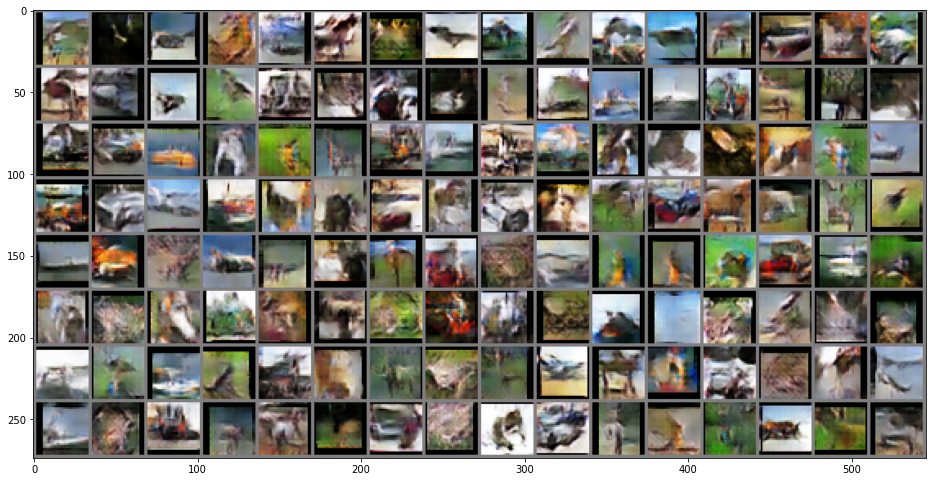

alomst 100
[8/10]: loss_d: 2.527, loss_g: 0.977
Accuracy Training regular:  0.6613
Accuracy Training adv:  0.4407
Accuracy Testing :  0.6664
Accuracy PGD:  0.4418
alomst 100
alomst 100


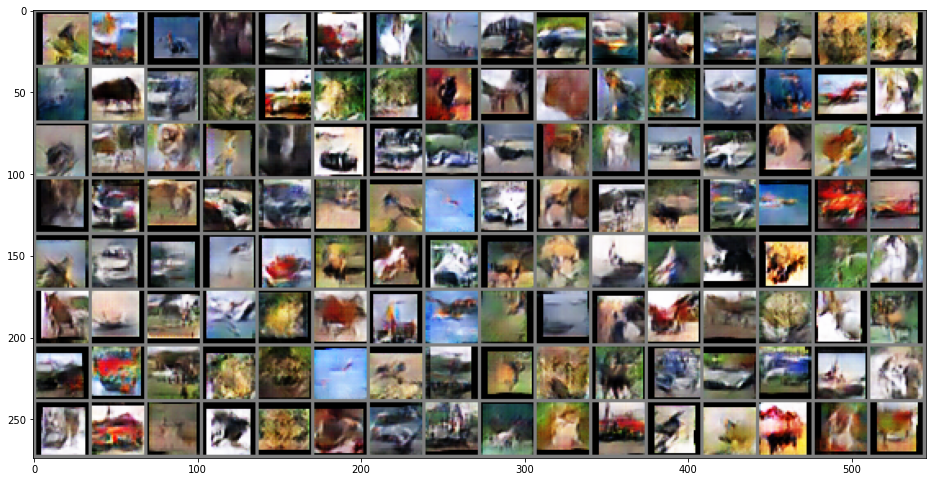

alomst 100
[9/10]: loss_d: 2.481, loss_g: 0.954
Accuracy Training regular:  0.6729
Accuracy Training adv:  0.4498
Accuracy Testing :  0.6666
Accuracy PGD:  0.4421
alomst 100
alomst 100


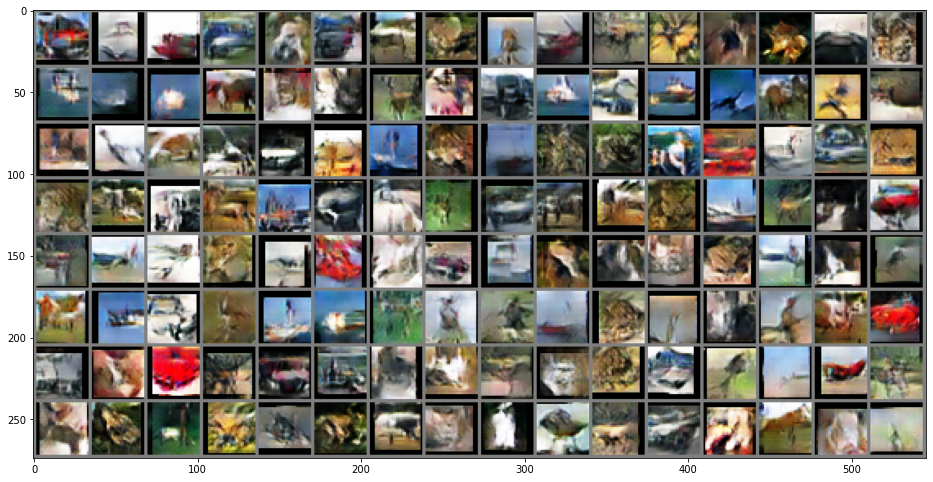

alomst 100
[10/10]: loss_d: 2.436, loss_g: 0.954
Accuracy Training regular:  0.6819
Accuracy Training adv:  0.4525
Accuracy Testing :  0.671
Accuracy PGD:  0.4431


In [21]:
#LR = 2e-3
#D_optimizer = optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))
#G_optimizer = optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
for epoch in range(1, n_epoch+1):
    #if epoch % 5 == 0:
    #  LR = LR/2
    #  D_optimizer = optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))
    #  G_optimizer = optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
    correct = 0
    total = 0    
    correct1 = 0
    total1 = 0
    Accuracy_train = []       
    D_losses, G_losses = [], []
        #=======================Train=======================#
    for batch_idx, (x, label) in enumerate(train_loader):
        #d  = D_train(x , label.cuda() , train = True)
        d  = D_train_adverserial(x , label.cuda() , train = True)
        d_loss = d['loss']
        output = d['output']
        outputP = d['outputP']
        
        g_loss , g_images= G_train(label.cuda())
        D_losses.append(d_loss)
        G_losses.append(g_loss)

        for idx ,i in enumerate(output):
          if torch.argmax(i) == label[idx]:
            correct += 1
          total += 1
        
        for idx ,i in enumerate(outputP):
          if torch.argmax(i) == label[idx]:
            correct1 += 1
          total1 += 1
        if batch_idx % 100 == 0 and not batch_idx == 0:
          print('alomst 100')
        if batch_idx % 250 == 0 and not batch_idx == 0:
          #print(label.size(0))
          #print(type(g_images))
          #print(type(g_images[1][1][1][1]))
          #print(g_images.dtype)
          g_images1 = g_images.reshape(BATCH_SIZE,3,img_dim,img_dim).float()
          #g_temp = g_images[0].float()
          #print(g_temp.dtype)
          #plt.imshow(np.transpose(g_temp.cpu().detach().numpy(), (1, 2, 0)), interpolation='nearest')
          display_grid(g_images1)
          
          #display_grid(x)
          #print('D(X) : {:}   || D(G(Z)) : {:}'.format(d_loss , g_loss))
    
    Accuracy_GAN_train.append(correct/total)
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    print('Accuracy Training regular: ' , round(correct/total , 4))
    print('Accuracy Training adv: ' , round(correct1/total1 , 4))
    correct = 0
    total = 0
    #=======================Test=======================#
    with torch.no_grad():
      for batch_idx, (x, label) in enumerate(test_loader):
          with torch.cuda.amp.autocast():
            d  = D_train_adverserial(x , label.cuda() , train = False)
            output = d['output']
          for idx ,i in enumerate(output):
            if torch.argmax(i) == label[idx]:
              correct += 1
            total += 1
      Accuracy_GAN_test.append(correct/total)
      print('Accuracy Testing : ' , round(correct/total , 4))
    #=======================Adverserial Test=======================# 
    correct = 0
    total = 0
    D.eval()
    for batch_idx, (x, label) in enumerate(test_loader):

      x = x.view(BATCH_SIZE, nc, img_dim, img_dim).cuda()
      img = x.clone()
      with torch.cuda.amp.autocast():
        x_perturb = perturb_image_pgd(img , D , label.cuda() , GAN = True)
      
      with torch.no_grad():
        with torch.cuda.amp.autocast():
        #new_img = fgsm(x , epsilon , data_grad)
          data = D(x_perturb)
          new_output = data['disc_classes']
        for idx , i in enumerate(new_output):
          if torch.argmax(i) == label[idx]:
            correct += 1
          total += 1
    D.train()
    Accuracy_GAN_FGSM.append(correct/total)
    print("Accuracy PGD: " , round(correct/total , 4))


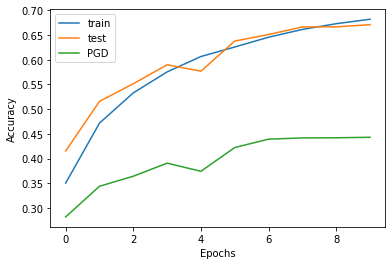

In [22]:
x1 = Accuracy_GAN_train
x2 = Accuracy_GAN_test
x3 = Accuracy_GAN_FGSM
plt.plot(x1  , label = 'train')
plt.plot(x2  ,  label = 'test')
plt.plot(x3 ,  label = 'PGD')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
#LR = 2e-3
#optimizer = optim.Adam(classifier.parameters(), lr = LR, betas=(0.5, 0.999))
for epoch in range(0, n_epoch): 
   # if epoch % 5 == 0:
   #   LR = LR/2
   #   optimizer = optim.Adam(classifier.parameters(), lr = LR, betas=(0.5, 0.999))
    #epochs.append(epoch)
    #=======================Train=======================#
    classifier.train()
    correct = 0
    total = 0
    correct1 = 0
    total1 = 0
    print('======== Epoch {:} / {:} ========'.format(epoch+1, n_epoch))          
    #D_losses, G_losses = [], []
    for batch_idx, (x, label) in enumerate(train_loader):
      
        optimizer.zero_grad()
        x_real = x.view(BATCH_SIZE, nc, img_dim, img_dim).cuda()
        img = x_real.clone()
        #adverserial trainig 
        with torch.cuda.amp.autocast(): 
          x_perturb = perturb_image_pgd(img , classifier , label.cuda() , GAN = False)
          output1 = classifier(x_perturb)
          loss1 = criterion_aux(output1 , label.cuda())
        #loss.backward()
        scaler.scale(loss1).backward() 
        with torch.cuda.amp.autocast():   
          output = classifier(x_real)
          loss = criterion_aux(output , label.cuda())
          #loss1.backward(retain_graph=True)
        scaler.scale(loss).backward() 
        #optimizer.step()
        scaler.step(optimizer) 
        scaler.update()
         

        new_loss = loss + loss1

        for idx ,i in enumerate(output):
          if torch.argmax(i) == label[idx]:
            correct += 1
          total += 1

        for idx ,i in enumerate(output1):
          if torch.argmax(i) == label[idx]:
            correct1 += 1
          total1 += 1

        if batch_idx % 375 == 0 and not batch_idx == 0: 
          #g_images = new_img.resize(BATCH_SIZE,nc,img_dim,img_dim)
          #display_grid(g_images)
          print('|| loss : {:} '.format(new_loss.mean().item())) 

    Accuracy_Clasf_train.append(correct/total)
    print('Accuracy Training regular: ' , round(correct/total , 4))
    print('Accuracy Training adv: ' , round(correct1/total1 , 4))
    #=======================Test=======================#    
    correct = 0
    total = 0
    classifier.train()
    with torch.cuda.amp.autocast():
      with torch.no_grad():
        for batch_idx, (x, label) in enumerate(test_loader):
          x_real = x.view(BATCH_SIZE, nc, img_dim, img_dim).cuda()
          output = classifier(x_real)
          for idx ,i in enumerate(output):
            if torch.argmax(i) == label[idx]:
              correct += 1
            total += 1
    Accuracy_Clasf_test.append(correct/total)
    print('Accuracy Testing : ' , round(correct/total , 4))
    #=======================Adverserial Test=======================# 
    correct = 0
    total = 0
    classifier.train()
    for batch_idx, (x, label) in enumerate(test_loader):
      with torch.cuda.amp.autocast():
        x = x.view(BATCH_SIZE, nc, img_dim, img_dim).cuda()
        img = x.clone()
        new_img = perturb_image_pgd(img , classifier , label.cuda() , GAN = False)
        new_output = classifier(new_img)
      

      for idx , i in enumerate(new_output):
        if torch.argmax(i) == label[idx]:
          correct += 1
        total += 1
    Accuracy_Clasf_FGSM.append(correct/total)
    print("Accuracy PGD: " , round(correct/total , 4))
    

======== Epoch 1 / 10 ========


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


|| loss : 3.301318645477295 
Accuracy Training regular:  0.357
Accuracy Training adv:  0.2716
Accuracy Testing :  0.4389
Accuracy PGD:  0.3084
======== Epoch 2 / 10 ========
|| loss : 2.905728340148926 
Accuracy Training regular:  0.4778
Accuracy Training adv:  0.3499
Accuracy Testing :  0.5241
Accuracy PGD:  0.3881
======== Epoch 3 / 10 ========
|| loss : 2.6035470962524414 
Accuracy Training regular:  0.5401
Accuracy Training adv:  0.3896
Accuracy Testing :  0.5702
Accuracy PGD:  0.4035
======== Epoch 4 / 10 ========
|| loss : 2.683936595916748 
Accuracy Training regular:  0.5857
Accuracy Training adv:  0.4172
Accuracy Testing :  0.6033
Accuracy PGD:  0.4274
======== Epoch 5 / 10 ========
|| loss : 2.8472061157226562 
Accuracy Training regular:  0.6159
Accuracy Training adv:  0.4394
Accuracy Testing :  0.6183
Accuracy PGD:  0.4368
======== Epoch 6 / 10 ========
|| loss : 2.563417434692383 
Accuracy Training regular:  0.6392
Accuracy Training adv:  0.4546
Accuracy Testing :  0.6483
Ac

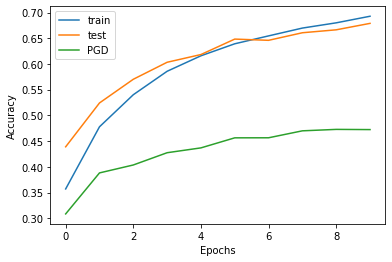

In [24]:
x1 = Accuracy_Clasf_train
x2 = Accuracy_Clasf_test
x3 = Accuracy_Clasf_FGSM
plt.plot(x1  , label = 'train')
plt.plot(x2  ,  label = 'test')
plt.plot(x3  ,  label = 'PGD')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()